In [1]:
import pandas as pd
import torch
from torch.utils.data import DataLoader
from torch import nn
import matplotlib.pyplot as plt

In [2]:
train_df = pd.read_csv('../data/Annotation/joined/joined_train.csv', index_col='id')
test_df = pd.read_csv('../data/Annotation/joined/joined_test.csv', index_col='id')
full_train_df = train_df.copy()
valid_df = train_df.sample(frac=0.15)
train_df = train_df.drop(valid_df.index)
print(train_df.shape)
print(valid_df.shape)
print(test_df.shape)

(10430, 772)
(1841, 772)
(3068, 772)


In [3]:
num_features = train_df.shape[1] - 1
num_labels = 7

In [4]:
def get_data_loaders(batch_size,
                     full_train_features, full_train_targets,
                     train_features, train_targets,
                     valid_features, valid_targets,
                     test_features, test_targets):
    full_train_dataset = CustomDataset(full_train_features, full_train_targets)
    full_train_data_loader = DataLoader(full_train_dataset, batch_size=batch_size, shuffle=True)
    train_dataset = CustomDataset(train_features, train_targets)
    train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_dataset = CustomDataset(valid_features, valid_targets)
    valid_data_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
    test_dataset = CustomDataset(test_features, test_targets)
    test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
    return full_train_data_loader, train_data_loader, valid_data_loader, test_data_loader

In [5]:
class CustomDataset(torch.utils.data.dataset.Dataset):
    def __init__(self, features, targets):
        self.features = features.to(torch.float32)
        self.targets = targets

    def __getitem__(self, index):
        ft = self.features[index]
        t = self.targets[index]
        return ft, t

    def __len__(self):
        return self.features.shape[0]

In [6]:
full_train_X, full_train_y = torch.tensor(full_train_df.drop(columns=['label']).values), torch.tensor(full_train_df['label'].values)
train_X, train_y = torch.tensor(train_df.drop(columns=['label']).values), torch.tensor(train_df['label'].values)
valid_X, valid_y = torch.tensor(valid_df.drop(columns=['label']).values), torch.tensor(valid_df['label'].values)
test_X, test_y = torch.tensor(test_df.drop(columns=['label']).values), torch.tensor(test_df['label'].values)

In [7]:
batch_size = 64
full_train_data_loader, train_data_loader, valid_data_loader, test_data_loader = get_data_loaders(batch_size,
                                                                          full_train_X, full_train_y,
                                                                          train_X, train_y,
                                                                          valid_X, valid_y,
                                                                          test_X, test_y)

In [8]:
class NeuralNetwork(nn.Module):
    def __init__(self, num_features, hidden_layers, num_targets, activation='sigmoid', dropout=0.0):
        """
        :param num_features: an integer denoting number of features, e.g., 784
        :param hidden_layers: a tuple of integers denoting hidden layer counts e.g., (4, 5, 6,)
        :param num_targets: an integer denoting number of targets, e.g., 10
        :param activation: activation function to be used between neural network layers
        :param dropout: probability of an element to be zeroed (for dropout layer)
        """
        super().__init__()

        if activation == 'sigmoid':
            activation_function = nn.Sigmoid()
        elif activation == 'relu':
            activation_function = nn.ReLU()
        else:
            raise ValueError('activation must be one of "sigmoid" or "relu"')

        layers = []
        layers.append(nn.Linear(num_features, hidden_layers[0]))
        if (dropout > 0.0):
            layers.append(nn.Dropout(dropout))
        layers.append(activation_function)

        for i in range(len(hidden_layers) - 1):
            layers.append(nn.Linear(hidden_layers[i], hidden_layers[i + 1]))
            if (dropout > 0.0):
                layers.append(nn.Dropout(dropout))
            layers.append(activation_function)
        layers.append(nn.Linear(hidden_layers[-1], num_targets))

        self.stack = nn.Sequential(*layers)

    def forward(self, x):
        logits = self.stack(x)
        return logits



In [9]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    train_loss, correct = 0, 0
    num_batches = len(dataloader)
    for X, y in dataloader:
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        train_loss += loss.item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_pred = pred.argmax(1)
        correct += (y_pred == y).type(torch.float).sum().item()

    train_loss /= num_batches
    correct /= size

    model_performance = {
        'train_loss': train_loss,
        'train_accuracy': 100 * correct
    }

    return model_performance


def test_loop(dataloader, model, loss_fn, isValidation=True):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    y_pred_lst = []
    y_lst = []

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            y_pred = pred.argmax(1)
            y_pred_lst += y_pred.tolist()
            y_lst += y.tolist()
            correct += (y_pred == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size

    model_performance = {
        'test_loss': test_loss,
        'test_accuracy': 100 * correct
    }
    
    if not isValidation:
        print(f"Test Performance: \n Accuracy: {(100 * correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
        model_performance.update({'y_pred': y_pred_lst, 'y_true': y_lst})

    return model_performance

In [10]:
import os
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report


def get_confusion_matrix(y_true, y_pred):
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
    plt.show()

    return None


def get_f1_score(y_true, y_pred):
    f1 = f1_score(y_true, y_pred, average='macro')
    return f1

def print_classification_report(y_true, y_pred):
    cls_report = classification_report(y_true, y_pred)
    print('\nClassification Report')
    print('======================================================')
    print('\n', cls_report)
    with open(os.path.join('../metrics', 'nn.txt'), 'w') as f:
        f.write(cls_report)

In [11]:
def execute_neural_network(epochs, train_data_loader,
                           neural_network, loss_fn, optimizer, valid_data_loader,
                           test_data_loader):
    train_loss = []
    validation_loss = []
    train_acc = []
    validation_acc = []


    for t in range(epochs):
        # training
        model_performance_train = train_loop(train_data_loader, neural_network, loss_fn, optimizer)
        train_loss.append(model_performance_train['train_loss'])
        train_acc.append(model_performance_train['train_accuracy'])
        if valid_data_loader is not None:
            # validation
            model_performance_valid = test_loop(valid_data_loader, neural_network, loss_fn)
            validation_loss.append(model_performance_valid['test_loss'])
            validation_acc.append(model_performance_valid['test_accuracy'])
        if t % 10 == 0:
            print(f'Iteration {t+1}')
            print(f"Training Performance: \n Accuracy: {model_performance_train['train_accuracy']:>0.1f}%, "
                  f"Avg loss: {model_performance_train['train_loss']:>8f}")
            if valid_data_loader is not None:
                print(f"Validation Performance: \n Accuracy: {model_performance_valid['test_accuracy']:>0.1f}%, "
                  f"Avg loss: {model_performance_valid['test_loss']:>8f}")
            print()

    # test
    model_performance_test = test_loop(test_data_loader, neural_network, loss_fn, isValidation=False)
    f1_score = get_f1_score(model_performance_test['y_true'], model_performance_test['y_pred'])
    print(f"\nF1 Score: {f1_score:>0.2f}")
    get_confusion_matrix(model_performance_test['y_true'], model_performance_test['y_pred'])
    print_classification_report(model_performance_test['y_true'], model_performance_test['y_pred'])

In [36]:
def classify_expressions(dropout=0.00, weight_decay=0.0001, learning_rate=2e-4, epochs=1500, valid=False):

    # Instantiate the neural network
    neural_network = NeuralNetwork(num_features, (8, 32, 8), num_labels)

    # Initialize loss and optimizer, and train/test the neural network
    loss_fn = nn.CrossEntropyLoss()
    adam_optimizer = torch.optim.Adam(neural_network.parameters(), lr=learning_rate, weight_decay=weight_decay)
    if valid:
        execute_neural_network(epochs, train_data_loader, neural_network, loss_fn, adam_optimizer, valid_data_loader,
                           test_data_loader)
    else:
        execute_neural_network(epochs, full_train_data_loader, neural_network, loss_fn, adam_optimizer, None,
                           test_data_loader)

Iteration 1
Training Performance: 
 Accuracy: 20.9%, Avg loss: 1.906721

Iteration 11
Training Performance: 
 Accuracy: 38.9%, Avg loss: 1.637863

Iteration 21
Training Performance: 
 Accuracy: 38.9%, Avg loss: 1.576796

Iteration 31
Training Performance: 
 Accuracy: 50.5%, Avg loss: 1.397971

Iteration 41
Training Performance: 
 Accuracy: 51.7%, Avg loss: 1.340969

Iteration 51
Training Performance: 
 Accuracy: 52.4%, Avg loss: 1.320133

Iteration 61
Training Performance: 
 Accuracy: 52.7%, Avg loss: 1.309898

Iteration 71
Training Performance: 
 Accuracy: 52.5%, Avg loss: 1.303580

Iteration 81
Training Performance: 
 Accuracy: 52.7%, Avg loss: 1.298620

Iteration 91
Training Performance: 
 Accuracy: 52.8%, Avg loss: 1.294700

Iteration 101
Training Performance: 
 Accuracy: 52.6%, Avg loss: 1.290355

Iteration 111
Training Performance: 
 Accuracy: 52.8%, Avg loss: 1.286232

Iteration 121
Training Performance: 
 Accuracy: 52.8%, Avg loss: 1.283101

Iteration 131
Training Performance: 

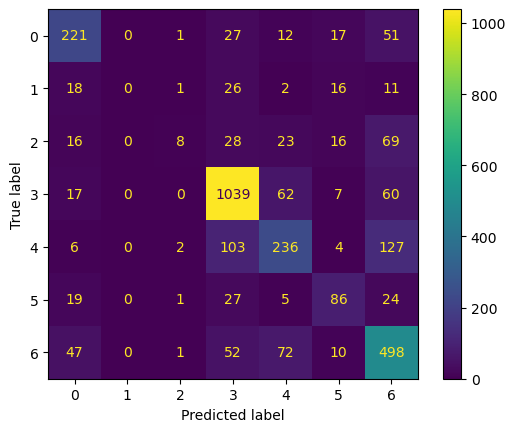


Classification Report

               precision    recall  f1-score   support

           0       0.64      0.67      0.66       329
           1       0.00      0.00      0.00        74
           2       0.57      0.05      0.09       160
           3       0.80      0.88      0.84      1185
           4       0.57      0.49      0.53       478
           5       0.55      0.53      0.54       162
           6       0.59      0.73      0.66       680

    accuracy                           0.68      3068
   macro avg       0.53      0.48      0.47      3068
weighted avg       0.66      0.68      0.65      3068



/Users/kushal/opt/anaconda3/envs/jupyter_lab/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kushal/opt/anaconda3/envs/jupyter_lab/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kushal/opt/anaconda3/envs/jupyter_lab/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

In [37]:
classify_expressions()